# The CIFAR-10 dataset

https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

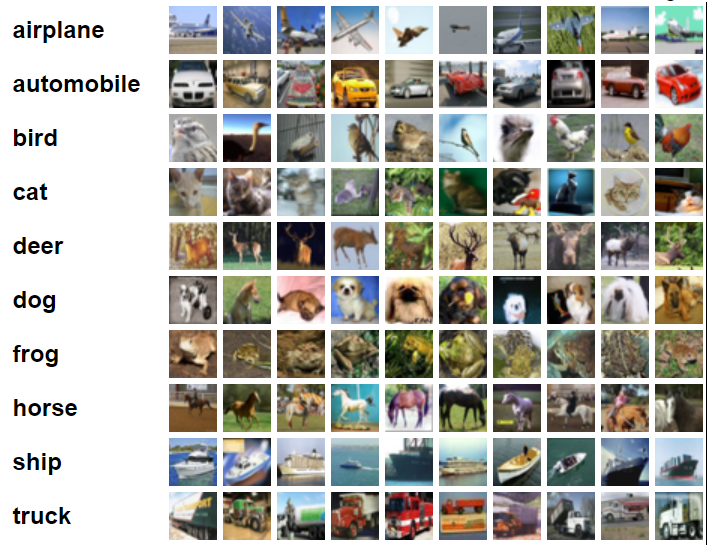

## Download the raw data files

In [ ]:
# Download CIFAR-10 dataset at https://www.cs.toronto.edu/~kriz/cifar.html
import urllib.request
urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "cifar-10-python.tar.gz")

!tar -xzvf '/content/cifar-10-python.tar.gz'

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


## "cifar-10-batches-py"
Inside the unzipped folder "cifar-10-batches-py", there are
* 5 training data batch files: 'data_batch_1', 'data_batch_2', to 'data_batch_5',
* 1 testting data batch file 'test_batch',  
* 1 file 'batch.meta', and
* 1 file 'readme.html'

Each of these batch files is a Python "pickled" object produced with cPickle.

Each of the data batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [ ]:
# Here is a method to to open the pickled file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

# for example
filepath = '/content/cifar-10-batches-py/data_batch_1'
data_batch_1 = unpickle(filepath)

print(type(data_batch_1))
print()

print(data_batch_1.keys())
print()

batch_1_dataItems = data_batch_1['data']
batch_1_labelItems = data_batch_1['labels']

print(type(batch_1_dataItems))
print(batch_1_dataItems.shape)
print()

print(type(batch_1_labelItems))
print(len(batch_1_dataItems))
print()

<class 'dict'>

dict_keys(['batch_label', 'labels', 'data', 'filenames'])

<class 'numpy.ndarray'>
(10000, 3072)

<class 'list'>
10000



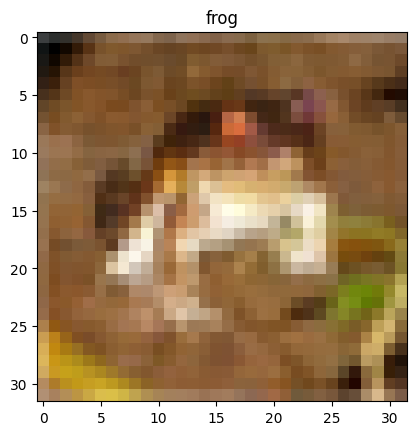

In [ ]:
# class names
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

import matplotlib.pyplot as plt
%matplotlib inline

idx = 0

img = data_batch_1['data'][idx].reshape(3, 32, 32).transpose(1,2,0).astype("uint8")

plt.imshow(img)
plt.title(class_names[data_batch_1['labels'][idx]])
plt.show()
print()

# Build a Custom Dataset

https://pytorch.org/docs/stable/data.html

PyTorch supports two different types of datasets:
* **map-style datasets**: a map-style dataset is one that implements the \_\_getitem\_\_() and \_\_len\_\_() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.
* **iterable-style datasets**: an iterable-style dataset is an instance of a subclass of IterableDataset that implements the \_\_iter\_\_() protocol, and represents an iterable over data samples.



---




https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

A custom Dataset class must implement three functions:
* **\_\_init\_\_()**: this function is run once when instantiating the Dataset object
* **\_\_getitem\_\_()**: this function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, retrieves the corresponding label, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
* **\_\_len\_\_()**: this function returns the number of samples in our dataset.


---

**Below presents a simplied implementation of a CustomDataset for CIFAR10.** The complete implementation can be found at https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html


Note that
* The **Dataset** retrieves our dataset’s features and labels one sample at a time.
* We have loaded that dataset into the **DataLoader** and can iterate through the dataset as needed.
>- While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

In [ ]:
import os
import pickle
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CustomDatasetCIFAR10(Dataset):
  base_folder = "cifar-10-batches-py"
  train_list = ["data_batch_1","data_batch_2","data_batch_3","data_batch_4","data_batch_5"]
  test_list = ["test_batch"]

  def __init__(self, root, train = True, transform = None, target_transform = None):
    super().__init__()
    self.root = root
    self.train = train
    self.transform = transform
    self.target_transform = target_transform

    if self.train:
      downloaded_list = self.train_list
    else:
      downloaded_list = self.test_list
    self.data = []
    self.targets = []

    for file_name in downloaded_list:
      file_path = os.path.join(self.root, self.base_folder, file_name)
      with open(file_path, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
        self.data.append(dict['data'])
        self.targets.extend(dict['labels'])
    self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
    self.data = self.data.transpose((0, 2, 3, 1))  # convert to Hight by Width by Channel

  def __getitem__(self, idx):
    img, target = self.data[idx], self.targets[idx]
    img = Image.fromarray(img)  # doing this so that it is consistent with all other datasets to return a PIL Image
    if self.transform is not None:
      img = self.transform(img)
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img, target

  def __len__(self):
    return len(self.data)

In [ ]:
data_path = "./"

cifar10 = CustomDatasetCIFAR10(data_path, train=True)

# Test the Dataset

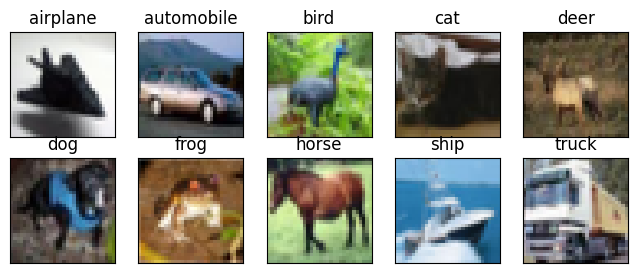

In [ ]:
# class names
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

# visualize by showing some images from the dataset
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)   #Here, we get a PIL (Python Imaging Library, the PIL package) image
    plt.imshow(img)
plt.show()

# Prepare Dataset objects

In [ ]:
from torchvision import transforms

data_path = './'

cifar10 = CustomDatasetCIFAR10(data_path, train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = CustomDatasetCIFAR10(data_path, train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

n_out = 10

# Prepare Dataloader objects


In [ ]:
import torch

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available()else {}

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True,  **kwargs)

val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,shuffle=False, **kwargs)

# Previous Example of Image Classification

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, n_out)
)

model.to(device)  # move model parameters to GPU for computation acceleration

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)   # move tensors to GPU for computation acceleration

        # imgs.view(imgs.shape[0], -1): In order to call the model, we need to make the input have the right dimensions.
        # We recall that our model expects 3,072 features in the input, and that nn works with data organized into batches along the zeroth dimension.
        # So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the zeroth position.
        outputs = model(imgs.view(imgs.shape[0], -1))
        train_loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)   # move tensors to GPU for computation acceleration

            outputs = model(imgs.view(imgs.shape[0], -1))
            val_loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f" % (epoch, float(train_loss), float(val_loss), (correct / total)))

cpu
Epoch: 0, train_loss: 2.099843, val_loss: 1.649716, val_accuracy: 0.381100
Epoch: 1, train_loss: 1.329339, val_loss: 1.704760, val_accuracy: 0.403900
Epoch: 2, train_loss: 1.493291, val_loss: 1.715566, val_accuracy: 0.422200
Epoch: 3, train_loss: 2.054823, val_loss: 1.569478, val_accuracy: 0.420300
Epoch: 4, train_loss: 1.839421, val_loss: 1.511267, val_accuracy: 0.440900
Epoch: 5, train_loss: 1.567960, val_loss: 1.539637, val_accuracy: 0.418100
Epoch: 6, train_loss: 1.008722, val_loss: 1.679642, val_accuracy: 0.444800
Epoch: 7, train_loss: 1.678894, val_loss: 1.510376, val_accuracy: 0.440400
Epoch: 8, train_loss: 1.117303, val_loss: 1.733899, val_accuracy: 0.448000
Epoch: 9, train_loss: 1.620252, val_loss: 1.686567, val_accuracy: 0.472200
Epoch: 10, train_loss: 1.165561, val_loss: 1.717836, val_accuracy: 0.472000
Epoch: 11, train_loss: 1.152903, val_loss: 1.820407, val_accuracy: 0.470100
Epoch: 12, train_loss: 1.429215, val_loss: 1.533428, val_accuracy: 0.466600
Epoch: 13, train_l

KeyboardInterrupt: ignored

# Some Notes



## Torchvision's built-in datasets vs the provided base classes

https://pytorch.org/vision/main/datasets.html#built-in-datasets

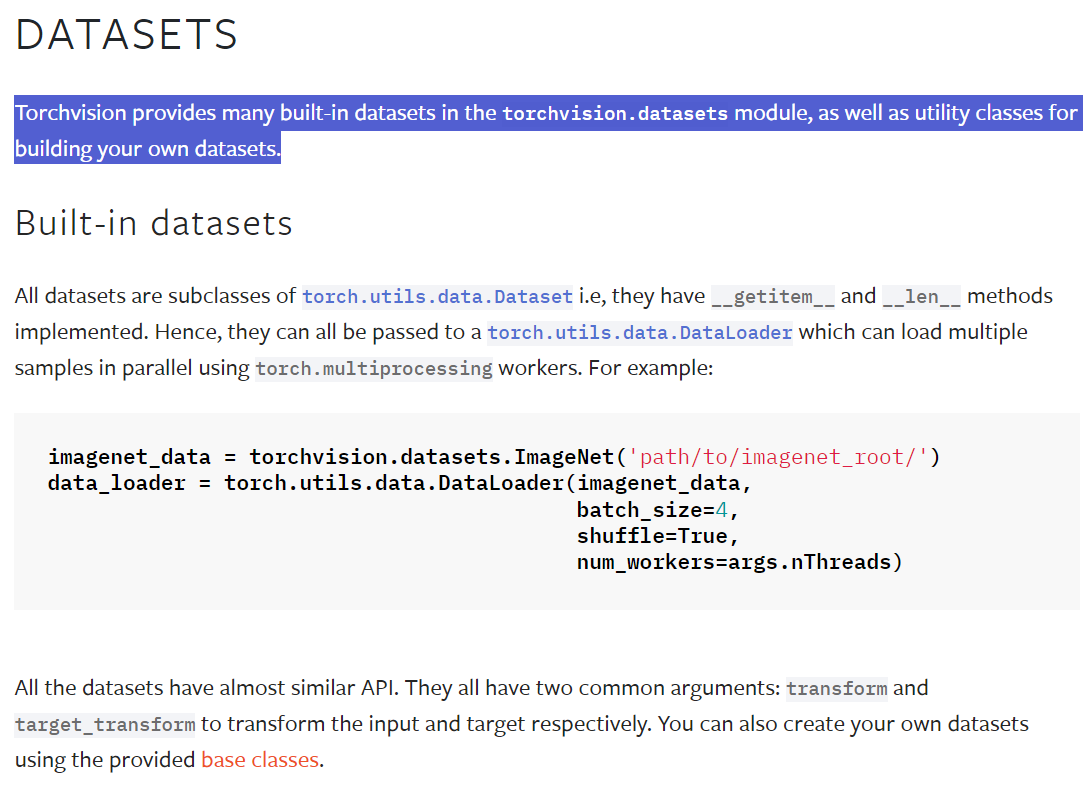



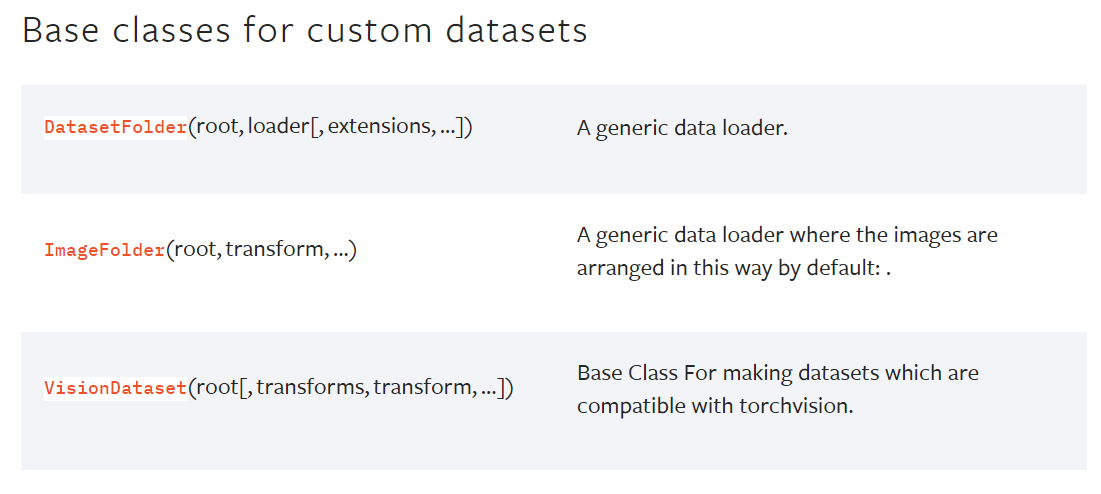

## torch.utils.data.TensorDataset

torch.utils.data.TensorDataset from a tensor.
https://pytorch.org/docs/stable/data.html

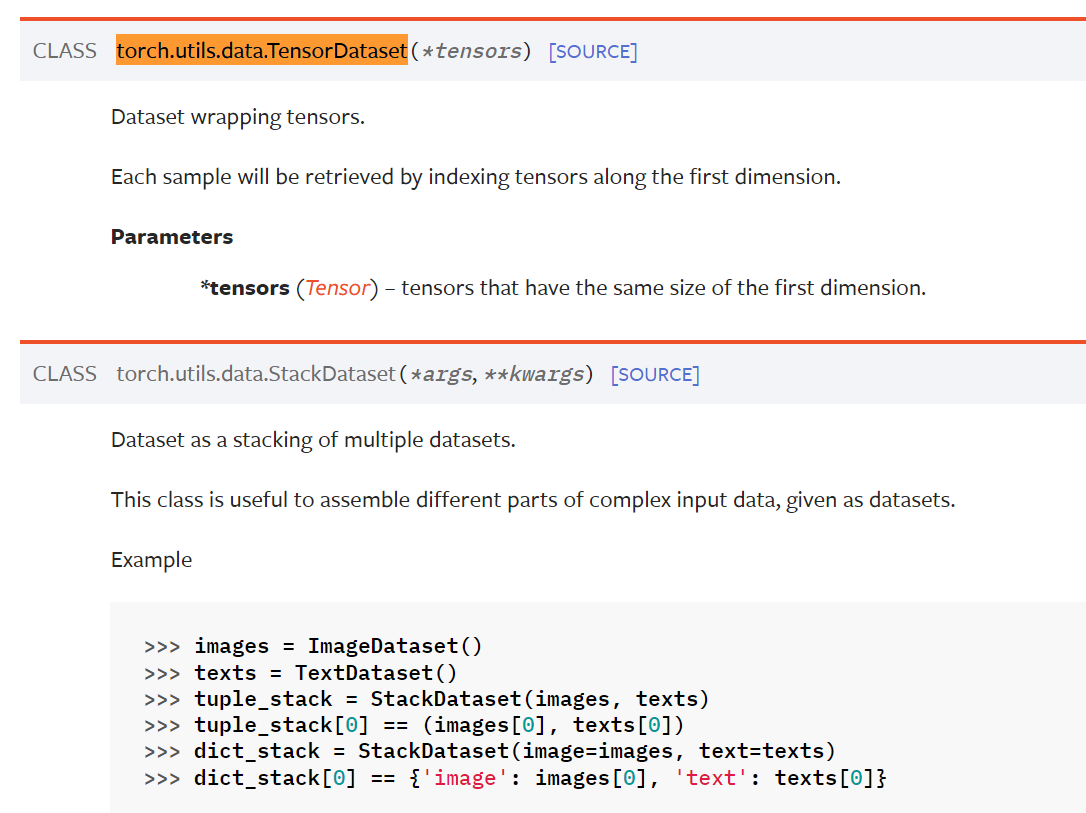


## torch.utils.data.random_split

https://pytorch.org/docs/stable/data.html

Randomly split a dataset into non-overlapping new datasets of given lengths; for example, training dataset, validation dataset, and testing dataset.

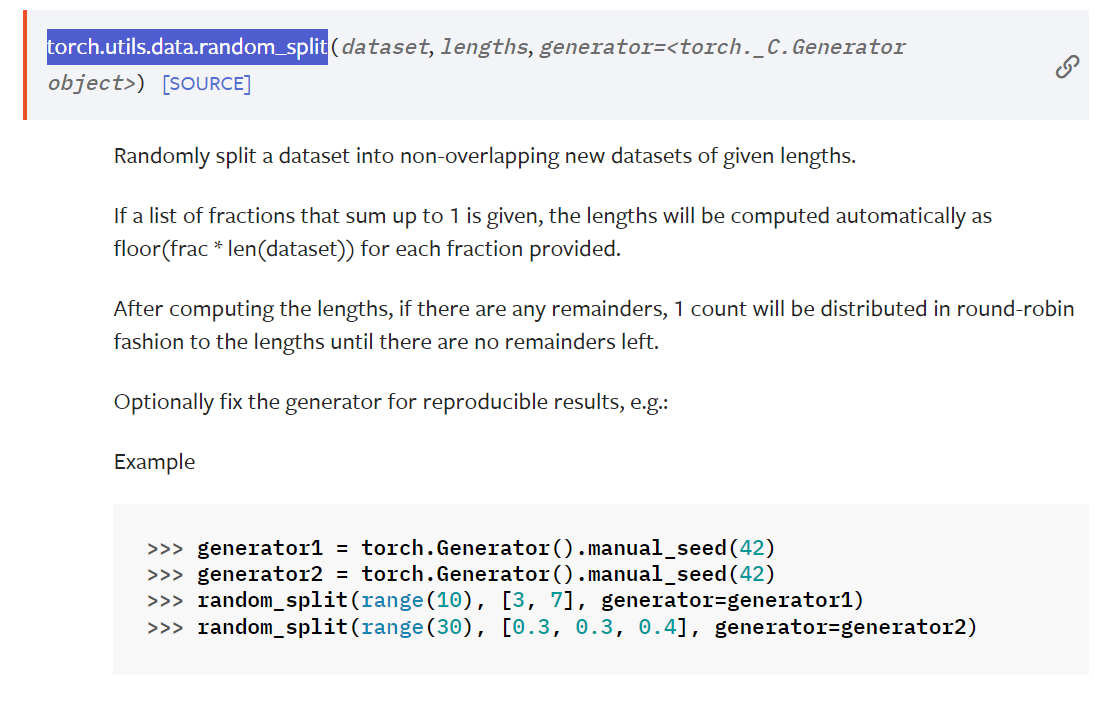